## m2: release

### Setup

In [2]:
import time
from datetime import timedelta

import pandas as pd
import numpy as np
from scipy import stats

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Model infrastructure
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics as sk_metrics

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Reductions
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap

# Regressions
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

### 1. Preprocessing

In [2]:
# Load data
df = pd.read_csv('data/red.csv', parse_dates=['release']).drop(columns=['popularity'])
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

print(f'Data train: {df_train.shape[0]} rows, {df_train.shape[1]} columns')
print(f'Data test: {df_test.shape[0]} rows, {df_test.shape[1]} columns')

Data train: 12000 rows, 519 columns
Data test: 3000 rows, 519 columns


In [3]:
# Drop NA values
n_orig = df_train.shape[0]
n_na = df_train['release'].isna().sum()
df_train = df_train.dropna(subset=['release'])
print(f'Train set: Dropped {n_na} NA entries of {n_orig}, {df_train.shape[0]} entries left.')
n_orig = df_test.shape[0]
n_na = df_test['release'].isna().sum()
df_test = df_test.dropna(subset=['release'])
print(f'Test set: Dropped {n_na} NA entries of {n_orig}, {df_test.shape[0]} entries left.')

Train set: Dropped 4158 NA entries of 12000, 7842 entries left.
Test set: Dropped 1022 NA entries of 3000, 1978 entries left.


In [4]:
# Bin y per year
df_train['release'] = df_train['release'].dt.year.astype(int)
df_test['release'] = df_test['release'].dt.year.astype(int)

In [5]:
# Scale X
X_train = df_train.drop(columns=['release'])
X_test = df_test.drop(columns=['release'])
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
print('')
print(f'Scaled train X:\n\tmean: {X_train.mean().tolist()[:5]}...\n\tstd: {X_train.std().tolist()[:5]}...')
print(f'Scaled test X:\n\tmean: {X_test.mean().tolist()[:5]}...\n\tstd: {X_test.std().tolist()[:5]}...')


Scaled train X:
	mean: [0.0, -5.4364402123955636e-18, 7.248586949860751e-18, 0.0, 0.0]...
	std: [1.0000637653436006, 1.0000637653436006, 1.0000637653436006, 1.0000637653436004, 1.0000637653436004]...
Scaled test X:
	mean: [-0.010753080391125295, 0.025948776780617095, -0.017322706532483273, -0.0064271753842954395, -0.010000670175294886]...
	std: [0.028161812373972788, 1.1116894140000593, 0.24411936736339307, 0.5801434183246433, 0.23964007106315588]...


### 2. Reductions

In [6]:
# Load data
df = pd.read_csv('data/red.csv',  parse_dates=['release']).drop(columns=['popularity'])

# Preprocess data
df = df.dropna(subset=['release'])
df['release'] = df['release'].dt.year.astype(int)
y = df['release']
X = df.drop(columns=['release'])

print(f'Data: {df.shape[0]} rows, {df.shape[1]} columns')

Data: 9820 rows, 519 columns


In [7]:
# Settings
n_feats = [2, 10, 25, 50, 100, 200, 300, 400, 500]
metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
scores = {'model':[], 'n_feats':[], 'mean_r2':[], 'mean_mse':[], 'mean_rmse':[], 'mean_mae':[]}

#### Benchmark

In [8]:
st = time.time()
name = 'lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('mod', LinearRegression())
])

parameters = {}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(518)
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:00:06


#### RFE - random feature elimination

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [9]:
st = time.time()
name = 'rfe_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_features_to_select': n_feats
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:03:33


#### PCA - principal component analysis

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

In [10]:
st = time.time()
name = 'pca_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', PCA(svd_solver='arpack', random_state=1)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_components': n_feats
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:00:45


#### KernelPCA - polynomial principal component analysis

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html?highlight=pca#sklearn.decomposition.KernelPCA)

In [11]:
st = time.time()
name = 'kpca_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', KernelPCA(kernel='poly', degree=2, eigen_solver='arpack', random_state=1)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_components': n_feats
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:10:20


#### ISOmap

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html?highlight=isomap#sklearn.manifold.Isomap)

In [12]:
st = time.time()
name = 'iso_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', Isomap(n_neighbors=10, eigen_solver='arpack', path_method='D', neighbors_algorithm='kd_tree')),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_components': n_feats
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:48:38


#### Results

In [13]:
results = pd.DataFrame(scores)
results.to_csv('results/m2_red_metrics.csv', index=False)
results.style\
    .hide(axis='index')\
    .highlight_quantile(subset=['mean_r2'], q_left=0.95, color='green')\
    .highlight_quantile(subset=['mean_r2'], q_right=0.05, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_left=0.95, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_right=0.05, color='green')

model,n_feats,mean_r2,mean_mse,mean_rmse,mean_mae
lr,518,-1.213847,52.767668,6.394710,3.266377
rfe_lr,2,0.003317,21.523694,4.629192,3.184248
rfe_lr,10,0.003793,21.510447,4.627893,3.185691
rfe_lr,25,0.023865,21.062650,4.580250,3.155411
rfe_lr,50,0.040081,20.702645,4.541303,3.126529
rfe_lr,100,0.048336,20.532654,4.522116,3.107017
rfe_lr,200,-0.152709,24.363548,4.922737,3.159556
rfe_lr,300,-0.919834,44.893243,6.108831,3.237642
rfe_lr,400,-1.073760,49.030267,6.265396,3.259096
rfe_lr,500,-1.250698,53.717601,6.432445,3.267552


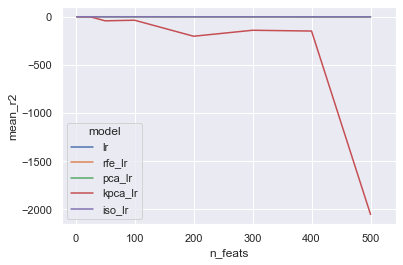

In [14]:
sns.lineplot(data=results, x='n_feats', y='mean_r2', hue='model');

### 3. Regressions

In [3]:
# Load data
df = pd.read_csv('data/reg.csv', parse_dates=['release']).drop(columns=['popularity'])

# Preprocess data
df = df.dropna(subset=['release'])
df['release'] = df['release'].dt.year.astype(int)
y = df['release']
X = df.drop(columns=['release'])

print(f'Data: {df.shape[0]} rows, {df.shape[1]} columns')

Data: 9778 rows, 519 columns


In [4]:
metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
scores = {'model':[], 'n_feats':[], 'mean_r2':[], 'mean_mse':[], 'mean_rmse':[], 'mean_mae':[]}

#### Benchmark

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [5]:
st = time.time()
name = 'rfe_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_features_to_select': [50, 100]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:01:21


#### Elastic net

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elastic%20net#sklearn.linear_model.ElasticNet)

In [6]:
st = time.time()
name = 'rfe_en'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', ElasticNet())
])

parameters = {
    'red__n_features_to_select': [50, 100]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:01:17


#### Polynomial regression

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomial%20features#sklearn.preprocessing.PolynomialFeatures)

In [7]:
st = time.time()
name = 'rfe_pr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('poly', PolynomialFeatures(degree=2)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_features_to_select': [50, 100]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:07:40


#### SVR - support vector regression

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR)

In [8]:
st = time.time()
name = 'rfe_svr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', SVR())
])

parameters = {
    'red__n_features_to_select': [50, 100]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:01:41


#### K-neighbors regression

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html?highlight=k%20neighbors#sklearn.neighbors.KNeighborsRegressor)

In [9]:
st = time.time()
name = 'rfe_kn'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', KNeighborsRegressor(algorithm='kd_tree'))
])

parameters = {
    'red__n_features_to_select': [50, 100]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:01:14


#### Results

In [10]:
results = pd.DataFrame(scores)
results.to_csv('results/m2_reg_metrics.csv', index=False)
results.style\
    .hide(axis='index')\
    .highlight_quantile(subset=['mean_r2'], q_left=0.9, color='green')\
    .highlight_quantile(subset=['mean_r2'], q_right=0.1, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_left=0.9, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_right=0.1, color='green')

model,n_feats,mean_r2,mean_mse,mean_rmse,mean_mae
rfe_lr,50,0.053707,19.121959,4.367289,3.052202
rfe_lr,100,0.054863,19.082125,4.363521,3.063650
rfe_en,50,-0.001549,20.239232,4.493104,3.140617
rfe_en,100,-0.001524,20.238791,4.493052,3.140592
rfe_pr,50,-0.238626,24.864741,4.982105,3.427386
rfe_pr,100,-4166.273365,77407.162102,151.351261,11.235076
rfe_svr,50,0.059398,19.028338,4.355278,2.930894
rfe_svr,100,0.067344,18.857449,4.336292,2.920667
rfe_kn,50,-0.048568,21.176764,4.595930,3.243841
rfe_kn,100,-0.042285,21.048852,4.582475,3.233079


### 4. Hyperparamter optimization

In [11]:
# Load data
df = pd.read_csv('data/hyper.csv', parse_dates=['release']).drop(columns=['popularity'])

# Preprocess data
df = df.dropna(subset=['release'])
df['release'] = df['release'].dt.year.astype(int)
# df = df.loc[df['release']>=1995]
y = df['release']
X = df.drop(columns=['release'])

print(f'Data: {df.shape[0]} rows, {df.shape[1]} columns')

Data: 9961 rows, 519 columns


In [12]:
metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
scores = {'model':[], 'n_feats':[], 'kernel':[], 'C':[], 'epsilon':[], 'mean_r2':[], 'mean_mse':[], 'mean_rmse':[], 'mean_mae':[]}

#### RFE + SVR

In [13]:
st = time.time()
name = 'rfe_svr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', SVR())
])

parameters = {
    'red__n_features_to_select': [90, 100, 110],
    'mod__kernel': ['linear', 'rbf', 'sigmoid'],
    'mod__C': [0.5, 1],
    'mod__epsilon': [0.5, 1]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['kernel'].append(cv_scores['params'][i]['mod__kernel'])
    scores['C'].append(cv_scores['params'][i]['mod__C'])
    scores['epsilon'].append(cv_scores['params'][i]['mod__epsilon'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:27:52


#### Results

In [16]:
results = pd.DataFrame(scores)
results.to_csv('results/m2_hyper_metrics.csv', index=False)
results.style\
    .hide(axis='index')\
    .highlight_quantile(subset=['mean_r2'], q_left=0.98, color='green')\
    .highlight_quantile(subset=['mean_r2'], q_right=0.02, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_left=0.98, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_right=0.02, color='green')

model,n_feats,kernel,C,epsilon,mean_r2,mean_mse,mean_rmse,mean_mae
rfe_svr,90,linear,0.500000,0.500000,0.035266,19.708107,4.433071,3.026544
rfe_svr,100,linear,0.500000,0.500000,0.037633,19.658089,4.427519,3.026141
rfe_svr,110,linear,0.500000,0.500000,0.040693,19.590351,4.420256,3.024137
rfe_svr,90,rbf,0.500000,0.500000,0.054570,19.313636,4.388769,2.980208
rfe_svr,100,rbf,0.500000,0.500000,0.057420,19.255299,4.382146,2.973657
rfe_svr,110,rbf,0.500000,0.500000,0.057798,19.246402,4.381199,2.972477
rfe_svr,90,sigmoid,0.500000,0.500000,-8.728413,195.176595,13.722181,7.239360
rfe_svr,100,sigmoid,0.500000,0.500000,-8.063710,180.253374,13.306666,6.969825
rfe_svr,110,sigmoid,0.500000,0.500000,-7.985321,180.635424,13.396740,7.018666
rfe_svr,90,linear,0.500000,1.000000,0.038397,19.641968,4.425750,3.024447


### 5. Final model

In [17]:
# Load data
df_train = pd.read_csv('data/hyper.csv',  parse_dates=['release']).drop(columns=['popularity'])
df_test = pd.read_csv('data/test.csv',  parse_dates=['release']).drop(columns=['popularity'])
df_test = df_test.sample(n=5000, random_state=1)

# Preprocess data
df_train = df_train.dropna(subset=['release'])
df_test = df_test.dropna(subset=['release'])

df_train['release'] = df_train['release'].dt.year.astype(int)
df_test['release'] = df_test['release'].dt.year.astype(int)

y_train = df_train['release']
y_test = df_test['release']

X_train = df_train.drop(columns=['release'])
X_test = df_test.drop(columns=['release'])

print(f'Data train: {df_train.shape[0]} rows, {df_train.shape[1]} columns')
print(f'Data test: {df_test.shape[0]} rows, {df_test.shape[1]} columns')

Data train: 9961 rows, 519 columns
Data test: 3250 rows, 519 columns


In [18]:
pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5, n_features_to_select=110)),
    ('mod', SVR(kernel='rbf', C=1, epsilon=1))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

r2 = round(sk_metrics.r2_score(y_test, y_pred), 6)
mse = round(sk_metrics.mean_squared_error(y_test, y_pred), 6)
mae = round(sk_metrics.mean_absolute_error(y_test, y_pred), 6)
print(f'Final model: R2: {r2}, MSE: {mse}, MAE:{mae}')

Final model: R2: 0.08129, MSE: 20.910945, MAE:2.943459
